#  Modelado de Topics

## Muestra de 2500 reviews +  Lemmatization

### Librerías y funciones necesarias

In [1]:
# Librería gensim (complementaria a Spacy)
# Librería pyLDAvis 
!pip install gensim
!pip install pyLDAvis

In [2]:
import random
import pandas as pd
import numpy as np
import os

import gensim
from gensim.corpora import Dictionary  # Diccionario clave:valor
from gensim.models import LdaModel, CoherenceModel  # Modelo LDA

import pyLDAvis  # Visualizar los clusters
import pyLDAvis.gensim
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# Sets the value of the specified option
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [3]:
# Función que realiza comprobaciones sobre una columna de un dataframe
def check_column(df, col_name):
    values_unique = len(df[col_name].unique())
    values_nan = df[col_name].isnull().sum()
    portmissing = round((df[col_name].isnull().sum()/len(df))*100, 4)
    
    print (f'{col_name} consta de: {values_unique} valores distintos de un total de {len(df)}')
    print (f'{col_name} consta de: {values_nan} valores ausentes, {portmissing}%')

### Lectura de datos

In [4]:
# Obtenemos la muestra del notebook anterior 2_ModeladoTopics.ipynb con los 2500 reviews obtenidos
# aleatoriamente del df_amazon
df_amazonfilter = pd.read_pickle('df_amazonfilter.pkl')
print(f'Dimensiones del dataset son: {df_amazonfilter.shape}')

Dimensiones del dataset son: (2500, 1)


In [5]:
# Columnas del df
df_amazonfilter.columns

Index(['reviewText'], dtype='object')

In [6]:
# Visualizamos las primeras filas
df_amazonfilter.head()

,reviewText
0,The watch does do everything it says it does. ...
1,Hatchet arrived covered in some oily substance...
2,"Forget the plodding, Octave. THIS is the Moood..."
3,I got this so I would have more room for clean...
4,[...] the reason why I gave this 2 stars is be...


### Lemmatization


Técnica de normalización de textos que busca reducir las palabras a su raíz (lemma) ya que en el notebook anterior se obtenían en los mismos topics, pares de palabras tales como:
    
    knife - knives
    product - products
    song - songs
    shoe - shoes

In [7]:
# Ruta del fichero en la que se encuentra el fichero para lemmatización en inglés
# Descargado de la URL https://github.com/michmech/lemmatization-lists
data_path = '../data'
lemmas_dict_file = 'lemmatization-en.txt'

In [8]:
# Función get_lemmas_dict 
def get_lemmas_dict(data_path, lemmas_dict_file):
    lemmas_dict = {}
    with open(os.path.join(data_path, lemmas_dict_file), 'r', encoding='utf-8') as f: 
        for line in f:
            (key, val) = line.split()
            lemmas_dict[str(val)] = key
    return lemmas_dict

In [9]:
# Obtenemos el diccionario de lemmas en inglés
lemmas_dict = get_lemmas_dict(data_path, lemmas_dict_file)
lemmas_dict

{'first': '\ufeff1',
 'tenth': '10',
 'hundredth': '100',
 'thousandth': '1000',
 'millionth': '1000000',
 'billionth': '1000000000',
 'eleventh': '11',
 'twelfth': '12',
 'thirteenth': '13',
 'fourteenth': '14',
 'fifteenth': '15',
 'sixteenth': '16',
 'seventeenth': '17',
 'eighteenth': '18',
 'nineteenth': '19',
 'second': '2',
 'twentieth': '20',
 'two-hundredth': '200',
 'twenty-first': '21',
 'twenty-second': '22',
 'twenty-third': '23',
 'twenty-fourth': '24',
 'twenty-fifth': '25',
 'twenty-sixth': '26',
 'twenty-seventh': '27',
 'twenty-eighth': '28',
 'twenty-ninth': '29',
 'third': '3',
 'thirtieth': '30',
 'three-hundredth': '300',
 'thirty-first': '31',
 'thirty-second': '32',
 'thirty-third': '33',
 'thirty-fourth': '34',
 'thirty-fifth': '35',
 'thirty-sixth': '36',
 'thirty-seventh': '37',
 'thirty-eighth': '38',
 'thirty-ninth': '39',
 'fourth': '4',
 'fortieth': '40',
 'four-hundredth': '400',
 'forty-first': '41',
 'forty-second': '42',
 'forty-third': '43',
 'forty-

In [10]:
# Comprobamos el par token-lemma con el primer registro
print('{0:15}{1:10}'.format('Token' ,'Lemma'))
for word in df_amazonfilter['reviewText'][25].split():
    print('{0:15}{1:10}'.format(word, lemmas_dict.get(word, word)))

Token          Lemma     
When           When      
I              I         
did            do        
a              a         
search         search    
on             on        
niacin,        niacin,   
I              I         
typed          type      
"flush         "flush    
free           free      
niacin         niacin    
1000mg"        1000mg"   
and            and       
this           this      
is             be        
the            the       
product        product   
that           that      
popped         pop       
up.            up.       
Though         Though    
the            the       
product        product   
description    description
said           say       
nothing        nothing   
about          about     
being          be        
"flush         "flush    
free",         free",    
I              I         
just           just      
assumed        assume    
it             it        
was            be        
since          since     
this       

Por ejemplo en el review 25 el lemma aplicado corresponde a la segunda columna:

    Palabras       Lemmas

    did            do
    assumed        assume 
    was            be
    returned       return 
    got            get  
    capsules       capsule   
    rivals         rival  
    most           much 

In [11]:
# Aplicamos la lemmatización sobre el df df_amazon_clean ya preprocesado
df_amazonfilter['reviewText']= df_amazonfilter['reviewText'].apply(lambda x: ' '.join([lemmas_dict.get(word, word) for word in x.split()]))

### Preprocesado

Aplicamos gensim.utils.simple_preprocess: Convert a document into a list of lowercase tokens, 

     ignoring tokens that are too short or too long.
     doc : str.     Input document.
     deacc : bool, optional.     Remove accent marks from tokens using :func:`~gensim.utils.deaccent`?
     min_len : int, optional.    Minimum length of token (inclusive). Shorter tokens are discarded.
     max_len : int, optional.    Maximum length of token in result (inclusive). Longer tokens are discarded.

In [12]:
# Función que realiza el preprocesado utilizando las librerías de gensim.utils.simple_preprocess
def text_preprocessing(text):
    result=[]
    for token in gensim.utils.simple_preprocess(text) :
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(token)
    return result

In [13]:
print('Original text:\n{}\n\n'.format(df_amazonfilter['reviewText'][2]))
print('Processed text:\n{}'.format(text_preprocessing(df_amazonfilter['reviewText'][2])))

Original text:
Forget the plodding, Octave. THIS be the Mooody Blues comeback album.Most of the song here be fantastic. The band be re-energized by the arrival of Patrick Moraz. "Talking Out Of Turn." be the well John Lodge solo vocal on any Moody Blues album from any era. "In My World" be a worthy addition to the Justin Hayward ballad catalogue. The only criticism be the Ray Thomas song be not on par with his classic work, and, consequently, be the weak song on the album.


Processed text:
['forget', 'plodding', 'octave', 'mooody', 'blues', 'comeback', 'album', 'song', 'fantastic', 'band', 'energized', 'arrival', 'patrick', 'moraz', 'talking', 'turn', 'john', 'lodge', 'solo', 'vocal', 'moody', 'blues', 'album', 'world', 'worthy', 'addition', 'justin', 'hayward', 'ballad', 'catalogue', 'criticism', 'thomas', 'song', 'classic', 'work', 'consequently', 'weak', 'song', 'album']


In [14]:
# lista de lista de documentos
processed_texts = []
for text in df_amazonfilter['reviewText']:
    processed_texts.append(text_preprocessing(text))

In [15]:
# Dimensiones del procesado de textos
len(processed_texts)

2500

In [16]:
# processed_texts[2] = text_preprocessing(df['text'][2])
print(processed_texts[2], '\n')
print('Original text:\n{}\n\n'.format(df_amazonfilter['reviewText'][2]))
print('Processed text:\n{}'.format(text_preprocessing(df_amazonfilter['reviewText'][2])))

['forget', 'plodding', 'octave', 'mooody', 'blues', 'comeback', 'album', 'song', 'fantastic', 'band', 'energized', 'arrival', 'patrick', 'moraz', 'talking', 'turn', 'john', 'lodge', 'solo', 'vocal', 'moody', 'blues', 'album', 'world', 'worthy', 'addition', 'justin', 'hayward', 'ballad', 'catalogue', 'criticism', 'thomas', 'song', 'classic', 'work', 'consequently', 'weak', 'song', 'album'] 

Original text:
Forget the plodding, Octave. THIS be the Mooody Blues comeback album.Most of the song here be fantastic. The band be re-energized by the arrival of Patrick Moraz. "Talking Out Of Turn." be the well John Lodge solo vocal on any Moody Blues album from any era. "In My World" be a worthy addition to the Justin Hayward ballad catalogue. The only criticism be the Ray Thomas song be not on par with his classic work, and, consequently, be the weak song on the album.


Processed text:
['forget', 'plodding', 'octave', 'mooody', 'blues', 'comeback', 'album', 'song', 'fantastic', 'band', 'energiz

In [17]:
processed_texts[2] == text_preprocessing(df_amazonfilter['reviewText'][2])

True

### Diccionario 

In [18]:
# Función que genera un diccionario id-palabra a partir de unos textos
def get_dictionary (texts) :
    # turn our tokenized documents into a id <-> term dictionary
    dictionary = Dictionary (texts)
    # dictionary . filter_extremes ( no_below =20 , no_above =0.5)
    # remove_n = 5 means number of the most frequent tokens that will be removed 
    dictionary.filter_n_most_frequent (5)
    return dictionary

In [19]:
# Creación de un diccionario id-palabra
dictionary = get_dictionary(processed_texts)
print(f'Longitud del diccionario: ', {len(dictionary)})

print('Diccionario id,palabra: ')
list(dictionary.items())

Longitud del diccionario:  {13931}
Diccionario id,palabra: 


[(0, 'away'),
 (1, 'bunch'),
 (2, 'certainly'),
 (3, 'control'),
 (4, 'download'),
 (5, 'effort'),
 (6, 'expensive'),
 (7, 'extra'),
 (8, 'figure'),
 (9, 'friendly'),
 (10, 'hard'),
 (11, 'heart'),
 (12, 'information'),
 (13, 'instruction'),
 (14, 'interaction'),
 (15, 'interface'),
 (16, 'intuitive'),
 (17, 'iphone'),
 (18, 'know'),
 (19, 'monitor'),
 (20, 'occasional'),
 (21, 'payoff'),
 (22, 'pull'),
 (23, 'real'),
 (24, 'software'),
 (25, 'spend'),
 (26, 'teeth'),
 (27, 'throw'),
 (28, 'user'),
 (29, 'want'),
 (30, 'watch'),
 (31, 'week'),
 (32, 'work'),
 (33, 'worse'),
 (34, 'worth'),
 (35, 'arrive'),
 (36, 'backpack'),
 (37, 'black'),
 (38, 'camp'),
 (39, 'cast'),
 (40, 'cover'),
 (41, 'cure'),
 (42, 'hand'),
 (43, 'hands'),
 (44, 'hatchet'),
 (45, 'heavy'),
 (46, 'husband'),
 (47, 'iron'),
 (48, 'leave'),
 (49, 'looked'),
 (50, 'mark'),
 (51, 'nicely'),
 (52, 'oily'),
 (53, 'smell'),
 (54, 'substance'),
 (55, 'addition'),
 (56, 'album'),
 (57, 'arrival'),
 (58, 'ballad'),
 (59, 

Como puede observarse las dimensiones del diccionario han disminuido con respecto al notebook anterior, es entendible al aplicar la lemmatization.

### Matriz documento-palabra (ó término)

In [20]:
# Función que genera un corpus dado un diccionario y unos textos
def get_corpus (dictionary, texts) :
    # convert tokenized documents into a document - term matrix
    # doc2bow (document): Convert `document` into the bag-of-words (BoW) format = list of `(token_id, token_count)` tuples.
    corpus = [dictionary.doc2bow(text) for text in texts]
    return corpus

In [21]:
# Creación de un corpus
corpus = get_corpus(dictionary, processed_texts)
print(f'Corpus: ')
corpus

Corpus: 


[[(0, 1),
  (1, 1),
  (2, 1),
  (3, 1),
  (4, 1),
  (5, 1),
  (6, 1),
  (7, 1),
  (8, 1),
  (9, 1),
  (10, 1),
  (11, 1),
  (12, 1),
  (13, 1),
  (14, 1),
  (15, 1),
  (16, 1),
  (17, 1),
  (18, 1),
  (19, 1),
  (20, 1),
  (21, 1),
  (22, 1),
  (23, 1),
  (24, 1),
  (25, 1),
  (26, 1),
  (27, 1),
  (28, 1),
  (29, 1),
  (30, 2),
  (31, 1),
  (32, 2),
  (33, 1),
  (34, 2)],
 [(35, 1),
  (36, 1),
  (37, 1),
  (38, 1),
  (39, 1),
  (40, 1),
  (41, 1),
  (42, 1),
  (43, 1),
  (44, 1),
  (45, 1),
  (46, 1),
  (47, 2),
  (48, 1),
  (49, 1),
  (50, 1),
  (51, 1),
  (52, 1),
  (53, 1),
  (54, 1)],
 [(32, 1),
  (55, 1),
  (56, 3),
  (57, 1),
  (58, 1),
  (59, 1),
  (60, 2),
  (61, 1),
  (62, 1),
  (63, 1),
  (64, 1),
  (65, 1),
  (66, 1),
  (67, 1),
  (68, 1),
  (69, 1),
  (70, 1),
  (71, 1),
  (72, 1),
  (73, 1),
  (74, 1),
  (75, 1),
  (76, 1),
  (77, 1),
  (78, 1),
  (79, 1),
  (80, 3),
  (81, 1),
  (82, 1),
  (83, 1),
  (84, 1),
  (85, 1),
  (86, 1),
  (87, 1)],
 [(32, 1),
  (88, 1),
  (89,

In [22]:
# Significa que las siguientes palabras o términos con id en el vocabulario se repiten el nº de veces indicado:
# lyrics con id 115 en el diccionario se repite 3 veces
# musicians con id 118 se repite 2 veces
print('Original  text:{}\n'.format(df_amazonfilter['reviewText'][2]))
print('Processed text:{}\n'.format(processed_texts[2]))
print('Corpus        :{}'.format(corpus[2]))


Original  text:Forget the plodding, Octave. THIS be the Mooody Blues comeback album.Most of the song here be fantastic. The band be re-energized by the arrival of Patrick Moraz. "Talking Out Of Turn." be the well John Lodge solo vocal on any Moody Blues album from any era. "In My World" be a worthy addition to the Justin Hayward ballad catalogue. The only criticism be the Ray Thomas song be not on par with his classic work, and, consequently, be the weak song on the album.

Processed text:['forget', 'plodding', 'octave', 'mooody', 'blues', 'comeback', 'album', 'song', 'fantastic', 'band', 'energized', 'arrival', 'patrick', 'moraz', 'talking', 'turn', 'john', 'lodge', 'solo', 'vocal', 'moody', 'blues', 'album', 'world', 'worthy', 'addition', 'justin', 'hayward', 'ballad', 'catalogue', 'criticism', 'thomas', 'song', 'classic', 'work', 'consequently', 'weak', 'song', 'album']

Corpus        :[(32, 1), (55, 1), (56, 3), (57, 1), (58, 1), (59, 1), (60, 2), (61, 1), (62, 1), (63, 1), (64, 1)

Tal y como se refleja en este review, estos son algunos términos/palabras junto con el nº de veces que se repite.
    
                 id     nº veces que se repite
    album        56     1                         (56, 3)
    blues        60     2                         (60, 2)
    song         80     3                         (80, 3)

### Entrenamiento del modelo LDA

#### Número óptimo de tokens

Para obtener el nº óptimo de topics se construyen varios modelos  LDA con diferente nº de topics (num_topics) y se toma aquel que devuelva el mayor valor de coherencia (coherence score). Este valor de coherencia es una forma simple de ver cómo de bueno es el modelo.

Pero también es cierto que para la elección de num_topics, el valor del coherence score no tiene porque ser necesariamente el más grande porque si por ejemplo se detectan las mismas palabras repetidas en muchos de los topics, esto significa que el parámetro num_topics es muy grande.



In [23]:
# Función que cálcula el valor de la coherencia entre varios modelos LDA y devuelve la lista de modelos junto con 
# la lista asociada del valor de la coherencia, de modo que podemos extraer el óptimo número de topics del modelo LDA
def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        
        # Build LDA model
        # random_state: parameter is fundamental if you want to reproduce the training run, its like a random seed
        # passes: number of passes through the corpus during training.
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                id2word=dictionary,
                                                num_topics=num_topics,
                                                passes=15,
                                                alpha='auto',
                                                random_state = 1)
        
        # Create a list of LDA models
        model_list.append(model)
        
        # Compute the Coherence for each model
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [24]:
start_ = 1   # Nº mínimo de topics
end_   = 12  # Nº máximo de topics
step_  = 1   # Salto de 1 en 1 

# LLamada a la función compute_coherence_values para el cálculo del nº óptimo de topics 
model_list, coherence_values = compute_coherence_values(
    dictionary=dictionary,
    corpus=corpus,
    texts=processed_texts,
    start=start_,
    limit=end_,
    step=step_
)

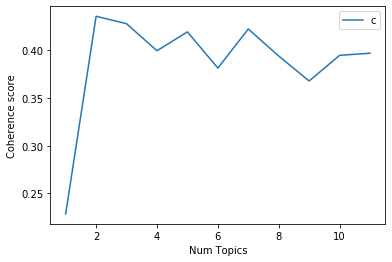

In [25]:
# Visualizamos el resultado del valor de la coherencia por cada topic
# de manera que el topic con mayor coherencia es el valor óptimo para el modelo
x = range(start_, end_, step_)
plt.plot(x, coherence_values)
plt.xlabel('Num Topics')
plt.ylabel('Coherence score')
plt.legend(('coherence_values'), loc='best')
plt.show()

In [26]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " con Coherence Score: ", round(cv, 4))

Num Topics = 1  con Coherence Score:  0.2286
Num Topics = 2  con Coherence Score:  0.4355
Num Topics = 3  con Coherence Score:  0.4277
Num Topics = 4  con Coherence Score:  0.3993
Num Topics = 5  con Coherence Score:  0.4191
Num Topics = 6  con Coherence Score:  0.3812
Num Topics = 7  con Coherence Score:  0.4221
Num Topics = 8  con Coherence Score:  0.3938
Num Topics = 9  con Coherence Score:  0.3677
Num Topics = 10  con Coherence Score:  0.3945
Num Topics = 11  con Coherence Score:  0.3968


    Estos resultados difieren del notebook anterior '2_ModeladoTopics.ipynb', de hecho el num_topics con mayor coherence score (0.4277) es 3  pero como la muestra de 2500 reviews debería contener al menos 4 topics siendo optimistas, optamos por elegir num_topics a 7 con coherence score algo menor 0.4221.
    
    De manera que con un num_topics diferente al del notebook anterior, vamos a verificar si afirmamos las conclusiones obtenidas anteriormente o no.

In [27]:
# Modelo LDA de gensim con el nº óptimo de topics seleccionados (num_topics a 10 con la posición 9)
num_topics = 7
optimal_model_id = 6

# Modelo con el óptimo nº de topics teniendo en cuenta la posición
optimal_model = model_list[optimal_model_id]

In [28]:
# Get a representation for selected topics
optimal_model.show_topics(num_topics)

[(0,
  '0.026*"size" + 0.024*"wear" + 0.017*"look" + 0.015*"shoe" + 0.013*"small" + 0.011*"order" + 0.010*"comfortable" + 0.010*"love" + 0.008*"color" + 0.007*"nice"'),
 (1,
  '0.043*"quot" + 0.009*"light" + 0.006*"country" + 0.004*"case" + 0.003*"wake" + 0.003*"lamp" + 0.002*"seat" + 0.002*"sound" + 0.002*"sweatshirt" + 0.002*"know"'),
 (2,
  '0.011*"work" + 0.009*"feel" + 0.009*"light" + 0.008*"product" + 0.007*"look" + 0.006*"need" + 0.005*"come" + 0.005*"water" + 0.005*"thing" + 0.004*"clean"'),
 (3,
  '0.013*"knife" + 0.010*"work" + 0.008*"product" + 0.007*"blade" + 0.006*"look" + 0.006*"shave" + 0.005*"amazon" + 0.005*"long" + 0.005*"fine" + 0.005*"come"'),
 (4,
  '0.010*"work" + 0.010*"product" + 0.006*"thing" + 0.006*"battery" + 0.005*"know" + 0.004*"easy" + 0.004*"year" + 0.004*"love" + 0.004*"feel" + 0.004*"brand"'),
 (5,
  '0.037*"album" + 0.028*"song" + 0.018*"quot" + 0.011*"track" + 0.009*"music" + 0.008*"sound" + 0.007*"love" + 0.006*"hear" + 0.005*"come" + 0.005*"band"')

In [29]:
# Conversión en pandas y muestra por topics las palabras o términos con mayor importancia
word_dict = {};
for i in range(num_topics):
    words = optimal_model.show_topic(i, topn = 20)
    word_dict['Topic #' + '{:02d}'.format(i+1)] = [i[0] for i in words]
pd.DataFrame(word_dict)

,Topic #01,Topic #02,Topic #03,Topic #04,Topic #05,Topic #06,Topic #07
0,size,quot,work,knife,work,album,strap
1,wear,light,feel,work,product,song,buffett
2,look,country,light,product,thing,quot,mask
3,shoe,case,product,blade,battery,track,need
4,small,wake,look,look,know,music,fishy
5,order,lamp,need,shave,easy,sound,nice
6,comfortable,seat,come,amazon,year,love,fruitcakes
7,love,sound,water,long,love,hear,fish
8,color,sweatshirt,thing,fine,feel,come,long
9,nice,know,clean,come,brand,band,quality


In [30]:
# Visualizamos las primeras palabras clave de cada topic (ahora en horizontal) junto al peso o valor de importancia
topics = optimal_model.print_topics(num_topics=-1, num_words=5)
t = []
for topic in topics:
    t.append(topic[1].split("+"))

sent_topics_df = pd.DataFrame(data=t,columns=["word1","word2","word3","word4","word5"])
sent_topics_df

,word1,word2,word3,word4,word5
0,"0.026*""size""","0.024*""wear""","0.017*""look""","0.015*""shoe""","0.013*""small"""
1,"0.043*""quot""","0.009*""light""","0.006*""country""","0.004*""case""","0.003*""wake"""
2,"0.011*""work""","0.009*""feel""","0.009*""light""","0.008*""product""","0.007*""look"""
3,"0.013*""knife""","0.010*""work""","0.008*""product""","0.007*""blade""","0.006*""look"""
4,"0.010*""work""","0.010*""product""","0.006*""thing""","0.006*""battery""","0.005*""know"""
5,"0.037*""album""","0.028*""song""","0.018*""quot""","0.011*""track""","0.009*""music"""
6,"0.009*""strap""","0.007*""buffett""","0.006*""mask""","0.004*""need""","0.004*""fishy"""


    Topic 1 - reviews referentes al calzado.
        {size, wear, look, shoe, small, order, comfortable, love, color, nice, .., boot, material, ..}
           
    Topic 2 - no detecto un topic con las palabras incluidas.
 
    Topic 3 - reviews con referencias a productos o consejos de cuidado  personal
       {work, feel, light, productt, look, need, come, water, thing, clean, quality, right, want, think,..}
           
    Topic 4 - es confuso identificar el topic, porque algunas palabras referencian al cuidado personal (hair, shave) junto con amazon.
        Podrían ser reviews de productos para el cuidado personal online
        {knife, work, product, blade, look, shave, amazon, long, ..., hair,.., price, ..}
    
    Topic 5 - es igualmente confuso pero podría tratarse de marcas de productos para el entrenamiento personal
        {work, product, thing, battery, know, easy, year, love, feel, brand, need, sure, change,..}
        
    Topic 6 - reviews relacionados con la música y su cuota de mercado:
        {album, song, quot, track, music, sound, love, hear, come, band, ...}
        
    Topic 7 -  no detecto un topic con las palabras incluidas, un grupo menciona comida (fish, buffett, fruitcakes) y otras como strap o glove o 
    military no entiendo que relación puede existir entre ellas.

Con lo cual, según este análisis de los 7 topics, sólo encuento con sentido en 5 topics: 
    
    Topic 1 - calzado
    Topic 3 - productos o consejos para el cuidado personal
    Topic 4 - referencias al cuidado personal físico junto con la venta online (Amazon)
    Topic 5 - productos de entrenamiento personal
    Topic 6 - música y su couta de mercado

### Calidad del modelo

#### Perplexity y Coherence Score 

In [31]:
# Perplexity # Medida de qué tan bueno es el modelo. Cuanto más bajo, mejor
print('\nPerplexity: ', optimal_model.log_perplexity(corpus))  

# Coherence Score del id del óptimo num_topics seleccionadoeste dato ya esta calculado en los apartados anteriores)
print('\nCoherence Score: ', coherence_values[optimal_model_id])


Perplexity:  -8.37113374053383

Coherence Score:  0.42213167914038446


### Visualización del modelo

In [32]:
# Enable the automatic display of visualizations in the IPython Notebook.
pyLDAvis.enable_notebook()
# Transforms the Gensim TopicModel and related corpus and dictionary into the data structures needed for the visualization
vis = pyLDAvis.gensim.prepare(optimal_model, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.082797 -0.259102       1        1  33.623524
2     -0.107589  0.006361       2        1  20.692076
3     -0.133491  0.017148       3        1  16.734024
4     -0.049376  0.035142       4        1  11.673386
0     -0.117143  0.012292       5        1  11.358814
1      0.205560  0.059838       6        1   3.372410
6      0.119241  0.128322       7        1   2.545758, topic_info=      Category         Freq            Term        Total  loglift  logprob
591    Default   725.000000            quot   725.000000  30.0000  30.0000
56     Default  1228.000000           album  1228.000000  29.0000  29.0000
80     Default   935.000000            song   935.000000  28.0000  28.0000
286    Default   300.000000            wear   300.000000  27.0000  27.0000
223    Default   320.000000            size   320.000000  26.0000  26.0000
738    Default   208.000000           knife   208.000000  25.0000  25.0000
222    Default   166.000000            shoe   166.000000  24.0000  24.0000
238    Default   491.000000            look   491.000000  23.0000  23.0000
357    Default   377.000000           track   377.000000  22.0000  22.0000
214    Default   330.000000           light   330.000000  21.0000  21.0000
133    Default   300.000000           music   300.000000  20.0000  20.0000
202    Default   268.000000           small   268.000000  19.0000  19.0000
200    Default   411.000000         product   411.000000  18.0000  18.0000
595    Default   133.000000     comfortable   133.000000  17.0000  17.0000
32     Default   603.000000            work   603.000000  16.0000  16.0000
219    Default   188.000000           order   188.000000  15.0000  15.0000
354    Default   314.000000           sound   314.000000  14.0000  14.0000
724    Default   115.000000           blade   115.000000  13.0000  13.0000
360    Default   102.000000           color   102.000000  12.0000  12.0000
198    Default   428.000000            love   428.000000  11.0000  11.0000
389    Default    87.000000            pair    87.000000  10.0000  10.0000
1092   Default    74.000000           strap    74.000000   9.0000   9.0000
176    Default    96.000000           shave    96.000000   8.0000   8.0000
210    Default    96.000000            foot    96.000000   7.0000   7.0000
1324   Default    78.000000            boot    78.000000   6.0000   6.0000
456    Default   296.000000            nice   296.000000   5.0000   5.0000
430    Default   150.000000           songs   150.000000   4.0000   4.0000
619    Default   156.000000            rock   156.000000   3.0000   3.0000
261    Default   156.000000           large   156.000000   2.0000   2.0000
674    Default   105.000000         battery   105.000000   1.0000   1.0000
56      Topic1  1227.429688           album  1228.274658   1.0893  -3.2915
80      Topic1   934.746521            song   935.631531   1.0890  -3.5639
430     Topic1   149.638626           songs   150.325195   1.0854  -5.3960
128     Topic1   140.177368          listen   140.901627   1.0848  -5.4613
309     Topic1   134.166763          record   134.960663   1.0840  -5.5051
130     Topic1   101.851311           lyric   102.534927   1.0833  -5.7807
84      Topic1    91.836372           vocal    92.520981   1.0825  -5.8842
1181    Topic1    87.068459            sing    87.757431   1.0821  -5.9375
828     Topic1    82.416656          guitar    83.100113   1.0817  -5.9924
1481    Topic1    66.259178          albums    66.940941   1.0797  -6.2106
1500    Topic1    62.486160          lyrics    63.173008   1.0790  -6.2693
606     Topic1    62.085121          catchy    62.775799   1.0789  -6.2757
816     Topic1    59.316601           debut    59.997997   1.0785  -6.3213
1712    Topic1    55.453789          eminem    56.133545   1.0778  -6.3886
892     Topic1    58.698666          talent    59.460960   1.0770  -6.3318
1247    Topic1    50.

In [33]:
pyLDAvis.save_html(vis, '../notebooks/results/topics_reviewsamazon_n7.html')

Cada burbuja en la parte izquierda representa un topic. 

Cuanto más grande la burbuja, más predominante es ese topic. En nuestra representación y según el apartado final "Distribución de topics en el corpus", los topics con menor distribución son los nº 2 y 7 que están asociados a las burbujas 6 (3.4%) y 7 (2.5%) respectivamente y que efectivamente su tamaño es menor por ejemplo con respecto a las burbujas 1 (33.6%) y 2 (20.7%) que referencian los topics 6 y 3 respectivamente.

Mapeo entre burbujas y topics:

    Burbuja 1  representa el Topic nº 6  (reviews de música y su cuota de mercado)
    Burbuja 2  representa el Topic nº 3  (reviews de productos o consejos para el cuidado personal)
    Burbuja 3  representa el Topic nº 4  (reviews sobre el cuidado personal físico junto con la venta online (Amazon))
    Burbuja 4  representa el Topic nº 5  (reviews de productos de entrenamiento personal)  --> salud (dietas o hábitos saludables)
    Burbuja 5  representa el Topic nº 1  (reviews sobre el calzado)
    Burbuja 6  representa el Topic nº 2  
    Burbuja 7  representa el Topic nº 7  

Si posicionamos el cursor sobre una burbuja, las palabras y el gráfico de la derecha se actualizan y estas palabras son las palabras clave más importantes para el topic asociado a dicha burbuja.

Si seleccionamos una palabra del gráfico de barras, observamos las burbujas en las cuales aparece por orden de importancia según el tamaño de la(s) burbuja(s), Por ejemplo si seleccionamos la palabra song en la burbuja 1 vemos que no se localiza en ninguna otra burbuja, al contrario que con la palabra work de la burbuja 2 que se muestra también en las burbujas 3, 4 y 5

Algunas burbujas que se solapan, es más la burbuja 5 se encuentra embebida en las burbujas 2 y 3. 
La burbuja 5 contiene reviews de calzado y los reviews de las burbujas 2 y 3 referencian al cuidado personal
Las burbujas 2 y 4 también se solapan porque en estos casos, comparten las mismas palabras.

Si se restringe el λ se observa las palabras con más importancia en todos los topics y podemos deducir en este caso que la burbuja 4 referencia a las palabras {organic, battery, protein, isolate, supplement, pedometer, laser, whitney, swallow, product, golf, hudson, diet,..., healthly, ..} y siendo más restrictivos podría tratarse de reviews relacionados con la salud, dietas o complementos saludables

### Topic dominante por texto

In [34]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num+1), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [35]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=processed_texts)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(20)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,5.0,0.6146,"work, product, thing, battery, know, easy, yea...","[watch, like, pull, teeth, interface, friendly..."
1,1,3.0,0.7613,"work, feel, light, product, look, need, come, ...","[hatchet, arrive, cover, oily, substance, smel..."
2,2,6.0,0.9887,"album, song, quot, track, music, sound, love, ...","[forget, plodding, octave, mooody, blues, come..."
3,3,1.0,0.3759,"size, wear, look, shoe, small, order, comforta...","[room, clean, guns, little, bite, fuzzy, surfa..."
4,4,6.0,0.5295,"album, song, quot, track, music, sound, love, ...","[reason, star, like, took, emotion, sort, slop..."
5,5,3.0,0.6095,"work, feel, light, product, look, need, come, ...","[start, quality, epilators, withstand, nick, p..."
6,6,4.0,0.9673,"knife, work, product, blade, look, shave, amaz...","[striper, clip, work, great, want, bend, work,..."
7,7,3.0,0.9766,"work, feel, light, product, look, need, come, ...","[good, product, emit, fragrant, smell, purpose..."
8,8,1.0,0.7387,"size, wear, look, shoe, small, order, comforta...","[foot, size, order, true, good, stretch, mater..."
9,9,4.0,0.5720,"knife, work, product, blade, look, shave, amaz...","[look, like, picture, smell, funny, want, char..."


    Para el documento nº 1, 5, 7, 11 y 18 --> topic dominante es el nº 3 (productos o consejos para el cuidado personal) con mayor % en Doc.nº 7 0.9766
    Para el documento nº 3, 8, 12, 16 y 17 --> topic dominante es el nº 1 (reviews sobre  calzado), con mayor % en Doc.nº 8 0.7387
    Para el documento nº 2, 4, 10, 13, 15 y 19 --> topic dominante es el nº 6 con reviews de música con mayor % en Doc.nº15 0.9912 

### Documento más representativo por topic

In [36]:
sent_topics_sorteddf_lda = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_lda = pd.concat([
        sent_topics_sorteddf_lda,
        grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
        axis=0)

# Reset Index    
sent_topics_sorteddf_lda.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_lda.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_lda

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,1.0,0.9950,"size, wear, look, shoe, small, order, comforta...","[love, color, boot, size, small, boot, shoe, l..."
1,2.0,0.9961,"quot, light, country, case, wake, lamp, seat, ...","[mientras, grupos, ingleses, mediados, redescu..."
2,3.0,0.9941,"work, feel, light, product, look, need, come, ...","[read, review, fine, timepiece, major, issue, ..."
3,4.0,0.9983,"knife, work, product, blade, look, shave, amaz...","[think, epilator, cross, mind, offer, braun, s..."
4,5.0,0.9954,"work, product, thing, battery, know, easy, yea...","[scale, accurate, weight, measurement, mainly,..."
5,6.0,0.9979,"album, song, quot, track, music, sound, love, ...","[june, english, rocker, electric, light, orche..."
6,7.0,0.9918,"strap, buffett, mask, need, fishy, nice, fruit...","[thing, notice, glove, quality, notch, good, l..."


### Distribución de topics en el corpus

In [37]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), num_topics)
df_topic_contribution = pd.DataFrame({'topic': topic_contribution.index, 'contribution': topic_contribution})
df_topic_contribution.reset_index(drop=True, inplace=True)

# Show
df_topic_contribution

,topic,contribution
0,6.0,0.2380
1,3.0,0.2308
2,1.0,0.2008
3,4.0,0.1812
4,5.0,0.1116
5,2.0,0.0192
6,7.0,0.0184


### Conclusiones

A partir de un dataset de 2500 reviews con lemmatization se ha aplicado la técnica topic modeling para la detección de los principales topics o temas, a los cuales referencian los usuarios desde la red y cuya interpretabilidad puede ser algo confusa:

    Topic 1 - calzado
    Topic 3 - productos o consejos para el cuidado personal
    Topic 4 - cuidado personal físico junto con la venta online (Amazon)
    Topic 5 - productos de entrenamiento personal)  --> salud (dietas o hábitos saludables)
    Topic 6 - música y su cuota de mercado  
    
En este caso, existe un topic bien definido diferenciado del resto según la visualización

    Topic 6 - música y su cuota de mercado  asociado a la burbuja 1
      
Un segundo topic, correspondería al cuidado personal con varios subtopics Topic 4, y 5 asociadas a las burbujas 3 y 4 con solapamiento mínimo, de modo que en caso pueden englobar por un lado dietas y hábitos saludables y por otro lado vinculado con la venta online (Amazon)

Un tercer topic, es la moda en el que se podría englobar el topic del calzado (burbuja 5 solapada con las burbujas anteriores 3 y 4 referentes al cuidado personal). 

Igualmente, no he encontado referencia a reviews de sports and outdoors con esta muestra porque estamos utilizando la misma muestra que en notebook anterior 2_ModeladoTopic.ipynb